In [10]:
import os
file_path = f"R11519_Lifetime_0.csv.vertex.csv"
print("Checking file path:", os.path.abspath(file_path))
print("File exists:", os.path.exists(file_path))


Checking file path: /eos/home-i00/d/dskorubs/SWAN_projects/start_session/R11519_Lifetime_0.csv.vertex.csv
File exists: True


In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression

def Gauss(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

def TwoGauss(x, A1, mu1, sigma1, A2, mu2, sigma2, C):
    return Gauss(x, A1, mu1, sigma1) + Gauss(x, A2, mu2, sigma2) + C

def calculate_error(bins, data, z_expected):
    hist, bin_edges = np.histogram(data, bins=bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    calculated_z = np.sum(hist * bin_centers)  
    return abs(calculated_z - z_expected)


def doAnalysis(vertex_file, second_file, cut):
    df = pd.read_csv(vertex_file)
    df = df.loc[df[cut] == 1]
    z_values = df["Z"]
    run_numbers = df["Run Number"].unique()
    
    df_second = pd.read_csv(second_file)
    fit_min, fit_max = -1000, 1000  
    z_expected = df_second["Expected z (mm)"].iloc[0]
    match = df_second[df_second["Run Number"].isin(run_numbers)]
    if not match.empty:
        fit_min = match["fit_min"].iloc[0] if "fit_min" in match.columns and not pd.isna(match["fit_min"].iloc[0]) else fit_min
        fit_max = match["fit_max"].iloc[0] if "fit_max" in match.columns and not pd.isna(match["fit_max"].iloc[0]) else fit_max
    
    best_bins = None
    min_error = float("inf")
    
    for bins in range(10, 501, 10):  
        error = calculate_error(bins, z_values, z_expected)
        if error < min_error:
            min_error = error
            best_bins = bins
    
    
    
    
    hist_values, bin_edges = np.histogram(z_values, bins=best_bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  
    
    mask = (bin_centers >= fit_min) & (bin_centers <= fit_max)
    bin_centers_fit = bin_centers[mask]
    hist_values_fit = hist_values[mask]
    
    left_mask = bin_centers_fit < np.mean(bin_centers_fit)
    right_mask = bin_centers_fit > np.mean(bin_centers_fit)
    
    A1_init = max(hist_values_fit[left_mask]) if np.any(left_mask) else 1
    A2_init = max(hist_values_fit[right_mask]) if np.any(right_mask) else 1
    mu1_init = np.average(bin_centers_fit[left_mask], weights=hist_values_fit[left_mask]) if np.any(left_mask) else fit_min
    mu2_init = np.average(bin_centers_fit[right_mask], weights=hist_values_fit[right_mask]) if np.any(right_mask) else fit_max
    s1_init = np.std(bin_centers_fit[left_mask]) if np.any(left_mask) else 1
    s2_init = np.std(bin_centers_fit[right_mask]) if np.any(right_mask) else 1
    C_init = np.median(hist_values_fit[:int(len(hist_values_fit) * 0.1)]) if len(hist_values_fit) > 0 else 0
    
    bounds_lower = [0, min(bin_centers_fit), 0, 0, min(bin_centers_fit), 0, 0]
    bounds_upper = [max(hist_values_fit), max(bin_centers_fit), np.std(bin_centers_fit),
                    max(hist_values_fit), max(bin_centers_fit), np.std(bin_centers_fit), max(hist_values_fit)]
    
    try:
        popt, pcov = curve_fit(TwoGauss, bin_centers_fit, hist_values_fit, 
                                p0=[A1_init, mu1_init, s1_init, A2_init, mu2_init, s2_init, C_init],
                                bounds=(bounds_lower, bounds_upper))
        z_position = (popt[1] + popt[4]) / 2
        z_error = np.sqrt(pcov[1,1] + pcov[4,4]) / 2 if pcov is not None else np.nan
    except:
        z_position, z_error = np.nan, np.nan
    
    plt.hist(z_values, bins=best_bins, histtype='step', edgecolor='black', density=True)
    x_fit = np.linspace(fit_min, fit_max, 1000)
    plt.plot(x_fit, TwoGauss(x_fit, *popt), color='red', linewidth=2, label='Total Fit')
    plt.plot(x_fit, Gauss(x_fit, popt[0], popt[1], popt[2]), color='blue', linestyle='dashed', linewidth=2, label="Gaussian 1")
    plt.plot(x_fit, Gauss(x_fit, popt[3], popt[4], popt[5]), color='green', linestyle='dashed', linewidth=2, label="Gaussian 2")
    plt.axhline(popt[6], color='gray', linestyle='dotted', linewidth=2, label='Background')
    plt.axvline(fit_min, color='red', linestyle='dashed', linewidth=2)
    plt.axvline(fit_max, color='red', linestyle='dashed', linewidth=2)
    plt.xlim(-1100, 1100)
    plt.legend()
    
    plt.savefig(f"{vertex_file}_plot.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Calculated Z-position: {z_position} ± {z_error} mm")
    return z_position

def Final(file):
    
     
    df_runs = pd.read_csv(file)
    run_numbers = df_runs["Run Number"]
    expected_z_positions = df_runs["Expected z (mm)"]
    electrodes = df_runs["Electrode"]
    
    
    calculated_z_positions = []
    for num in run_numbers:
        z_position = doAnalysis(f"R{num}_Lifetime_0.csv.vertex.csv", file, "CutsType1")
        calculated_z_positions .append(z_position)
    calculated_z_positions = np.array(calculated_z_positions).reshape(-1, 1)
    expected_z_positions = np.array(expected_z_positions)
    model = LinearRegression().fit(calculated_z_positions, expected_z_positions)
    plt.scatter(calculated_z_positions, expected_z_positions, label="Data")
    plt.plot(calculated_z_positions, model.predict(calculated_z_positions), color='red', label=f"Fit: y={model.coef_[0]:.2f}x+{model.intercept_:.2f}")
    plt.xlabel("Calculated Z-position")
    plt.ylabel("Expected Z-position")
    plt.legend()
    plt.title("Comparison of Expected and Calculated Z-positions")
    plt.show()
    
    print(f"Linear Fit: y = {model.coef_[0]:.2f} * x + {model.intercept_:.2f}")
    
   
    
    
    
    
    

    

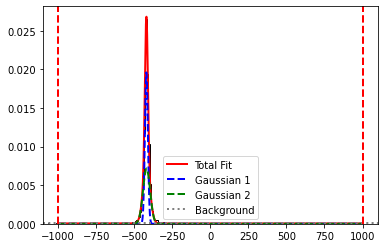

Calculated Z-position: -419.81001705738544 ± 0.11595087379780843 mm


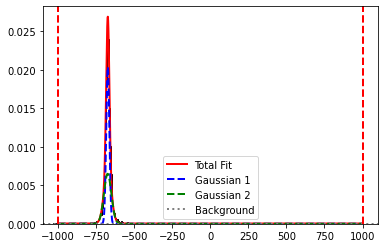

Calculated Z-position: -674.3995482374785 ± 0.17203152564841673 mm


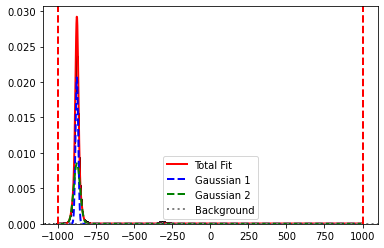

Calculated Z-position: -877.0558319542802 ± 0.0813493454830479 mm


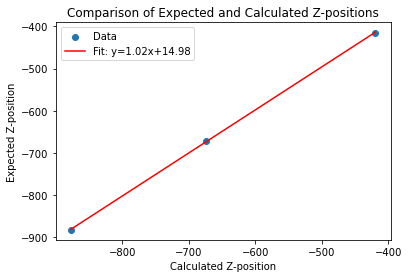

Linear Fit: y = 1.02 * x + 14.98


In [6]:
Final("runs_positions.csv")